# Predicting Proteomics Data from Transcriptomics and Methylation Data - A Transformer Approach 🔬🧬

## Overview 

This study uses three lung cancer datasets (methylation, transcriptomics, and proteomics) as an initial foundation for protein expression prediction. These datasets represent a biological hierarchy where proteomics is downstream of both methylation and transcriptomics in the cellular regulatory process, hence I thought that this might be a good place to start. Methylation regulates gene expression, which drives RNA transcription, ultimately leading to protein synthesis.

⌛️🔄🔃 Loading utils...

In [1]:

from utils.utils import *
from utils.transformer_utils import *

# Set random seed
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set fixed seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For CUDA GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Using device: cpu


⌛️🔄🔃 Loading data...

In [9]:
# Define paths to the datasets
data_folder = "/Users/uw20204/Downloads/Lung"
file_paths = {
    'proteomics': os.path.join(data_folder, "20231023_092657_imputed_proteomics.csv"),
    'transcriptomics': os.path.join(data_folder, "20231023_092657_imputed_transcriptomics.csv"),
    'methylation': os.path.join(data_folder, "20231023_092657_imputed_methylation.csv")
}

# Load datasets
datasets = {}
for name, path in file_paths.items():
    datasets[name] = load_dataset(path)
    if datasets[name] is not None:
        print(f"Loaded {name} dataset with shape {datasets[name].shape}")

Loaded proteomics dataset with shape (175, 4922)
Loaded transcriptomics dataset with shape (175, 15278)
Loaded methylation dataset with shape (175, 14608)


🔎 Next we align samples in the datasets...

In [10]:
common_samples = get_common_samples(datasets)

# Align datasets to common samples
aligned_datasets = {}
for name, df in datasets.items():
    if df is not None:
        aligned_datasets[name] = df.loc[common_samples]
        print(f"Aligned {name} dataset: {aligned_datasets[name].shape}")


Number of common samples across all datasets: 175
Aligned proteomics dataset: (175, 4922)
Aligned transcriptomics dataset: (175, 15278)
Aligned methylation dataset: (175, 14608)


## Data pre-processing 🛠 

### Step 1: Filtering protein targets
I selected proteomics features above the 70th percentile of variance to focus the analysis on proteins with biologically significant expression variation. This threshold was arbitrary and has not been optimised, but serves as a reasonable balance to remove constitutively expressed proteins and technical noise while retaining dynamically regulated proteins relevant to lung cancer.

In [11]:
# Select high variance features for proteomics
selected_proteomics = select_high_variance_features(
    aligned_datasets['proteomics'],
    threshold_percentile=70
)

Selected 1477 out of 4922 features based on variance percentile 70


### Step 2: Reducing dimensionality of transcriptomics and methylation datasets using PCA 📉

I applied PCA to the transcriptomics and methylation datasets, retaining components that explain 99% of variance. This approach reduces dimensionality while preserving nearly all biological signal. The analysis required 66 principal components (the maximum needed between both datasets) to capture 99% of variance.

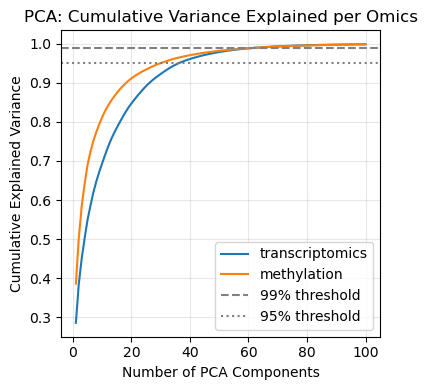


Using 64 PCA components for all input omics (≥99% variance)

Top 20 Protein-Transcript Correlations:
       protein transcript  correlation
1425       VIM        VIM     0.944489
668      ITGB1      ITGB1     0.940554
87       ANXA2      ANXA2     0.938283
987       PLEC       PLEC     0.937389
730       LMNA       LMNA     0.933060
1241      SQOR       SQOR     0.931422
846      NCEH1      NCEH1     0.931340
697      KRT18      KRT18     0.928462
108       ASPH       ASPH     0.927597
1045     PSIP1      PSIP1     0.926273
701       KRT7       KRT7     0.920121
439      ERBIN      ERBIN     0.919941
702       KRT8       KRT8     0.917842
698      KRT19      KRT19     0.913685
771   MARCKSL1   MARCKSL1     0.913145
1008      PON2       PON2     0.912345
998        PML        PML     0.911221
642      IKBIP      IKBIP     0.908551
1351     TRIT1      TRIT1     0.907855
664      ITGA3      ITGA3     0.906618


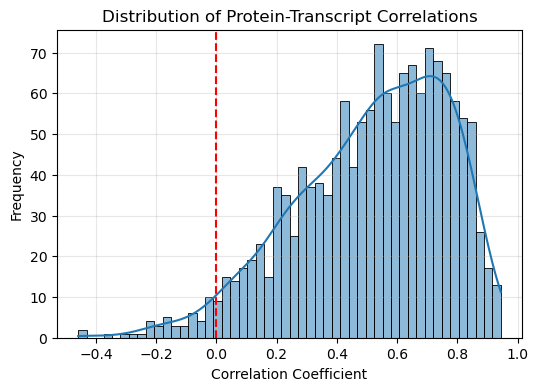

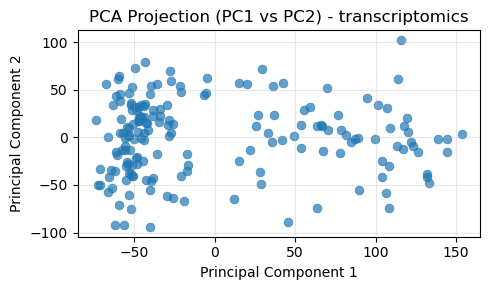

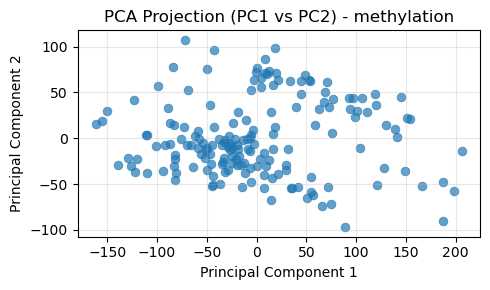

In [12]:
# Analyse and reduce dimensionality of input datasets using PCA
input_omics = ['transcriptomics', 'methylation']
explained_variance_ratios = {}
pca_datasets = {}
pca_models = {}
pca_scalers = {}
components_needed = {}

# Process each omics dataset
for omics in input_omics:
    if omics in aligned_datasets and aligned_datasets[omics] is not None:
        data = aligned_datasets[omics]
        
        # Scale the data
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
        pca_scalers[omics] = scaler
        
        # Fit PCA to analyse explained variance 
        max_components = min(100, data_scaled.shape[1])
        pca = PCA(n_components=max_components)
        pca_result = pca.fit_transform(data_scaled)
        
        # Store explained variance and PCA model
        explained_variance_ratios[omics] = pca.explained_variance_ratio_.cumsum()
        pca_models[omics] = pca
        
        # Determine components needed for target variance at 99%
        target_variance = 0.99
        components_needed[omics] = (explained_variance_ratios[omics] >= target_variance).argmax() + 1
        
        # Store PCA-transformed data (all components)
        pca_datasets[omics] = pca_result

# Plot cumulative explained variance
plt.figure(figsize=(4, 4))
for omics, cum_var in explained_variance_ratios.items():
    plt.plot(range(1, len(cum_var) + 1), cum_var, label=omics)
plt.axhline(0.99, color='gray', linestyle='--', label='99% threshold')
plt.axhline(0.95, color='gray', linestyle=':', label='95% threshold')
plt.xlabel("Number of PCA Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Cumulative Variance Explained per Omics")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Use unified number of components for all omics types
n_components = max(components_needed.values())
print(f"\nUsing {n_components} PCA components for all input omics (≥{int(target_variance*100)}% variance)")

# Truncate PCA datasets to the unified number of components
for omics in pca_datasets:
    pca_datasets[omics] = pca_datasets[omics][:, :n_components]

# Calculate gene correlations for biological insights
gene_correlations = find_gene_correlations(
    selected_proteomics,
    aligned_datasets['transcriptomics']
)
top_correlations = gene_correlations.sort_values('correlation', ascending=False).head(20)
print("\nTop 20 Protein-Transcript Correlations:")
print(top_correlations)

# Plot correlation distribution
plt.figure(figsize=(6, 4))
sns.histplot(gene_correlations['correlation'], bins=50, kde=True)
plt.title('Distribution of Protein-Transcript Correlations')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(True, alpha=0.3)
plt.show()

# PCA scatter plots (first 2 PCs) per omics
for omics in pca_datasets:
    pca_data = pca_datasets[omics]
    pca_df = pd.DataFrame(
        pca_data[:, :2],  # Take first 2 components
        columns=["PC1", "PC2"], 
        index=aligned_datasets[omics].index  # Use original indices
    )
    
    plt.figure(figsize=(5, 3))
    sns.scatterplot(
        data=pca_df,
        x="PC1", y="PC2",
        edgecolor=None, s=40, alpha=0.7
    )
    plt.title(f"PCA Projection (PC1 vs PC2) - {omics}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## Step 3: Train test splits & oversampling strategy

I constructed the machine learning pipeline by selecting high-variance proteins as targets and using PCA-reduced omics data as predictive features. I implemented an early fusion approach by concatenating PCA components from transcriptomics and methylation datasets to create a unified feature matrix. I used an 80/20 train-test split with 5-fold cross-validation that incorporates moderate oversampling (factor of 2) within training folds only.

The oversampling strategy divides samples into five expression-level bins based on mean protein values, then applies stratified sampling with replacement using inverse frequency weights. This approach doubles the effective training set size whilst preserving the natural distribution of protein expression patterns.


Input feature matrix shape after PCA: (175, 128)
Target matrix shape: (175, 1477)

Oversampling Diagnosis:
Original Data Bin Counts: [23 22 22 22 23]
Oversampled Data Bin Counts: [46 44 44 49 41]


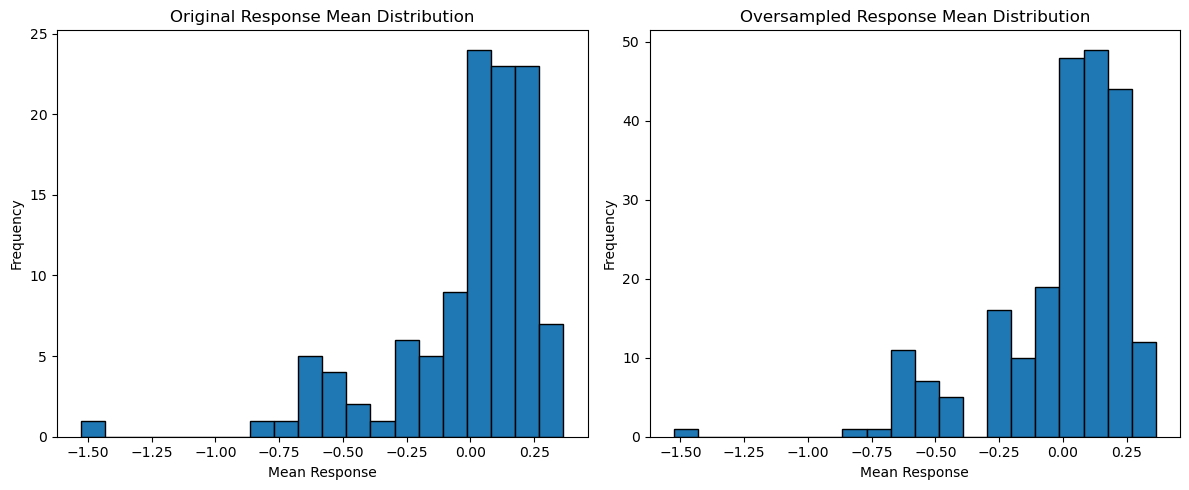


Original Data:
Number of samples: 112
Feature dimensions: 128

Oversampled Data:
Number of samples: 224
Feature dimensions: 128

Statistical Comparison:
Original Data Mean: -0.013211618955466175
Original Data Std: 0.297751026220765
Oversampled Data Mean: -0.005495486407199054
Oversampled Data Std: 0.26799386637362815

Oversampling Diagnosis:
Original Data Bin Counts: [23 22 22 22 23]
Oversampled Data Bin Counts: [46 44 44 46 44]


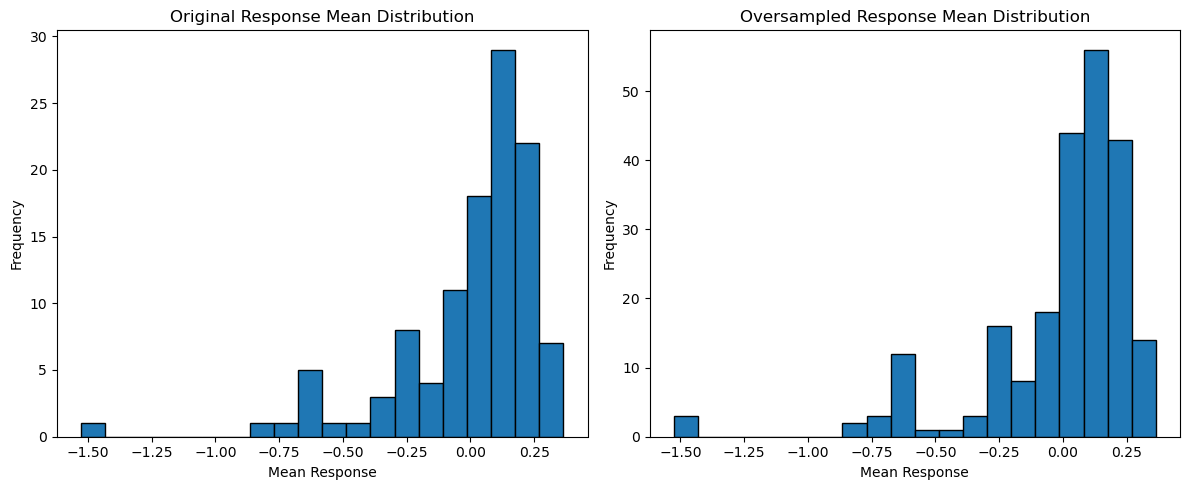


Original Data:
Number of samples: 112
Feature dimensions: 128

Oversampled Data:
Number of samples: 224
Feature dimensions: 128

Statistical Comparison:
Original Data Mean: -0.003287218156432528
Original Data Std: 0.2888580474468931
Oversampled Data Mean: -0.007796286873080728
Oversampled Data Std: 0.30980826460579236

Oversampling Diagnosis:
Original Data Bin Counts: [23 22 22 22 23]
Oversampled Data Bin Counts: [46 44 44 45 45]


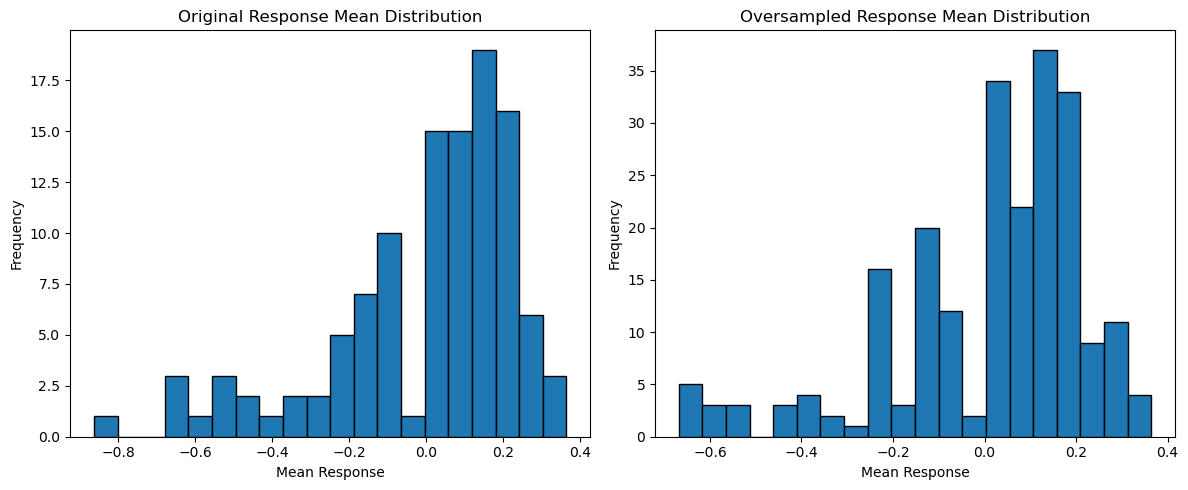


Original Data:
Number of samples: 112
Feature dimensions: 128

Oversampled Data:
Number of samples: 224
Feature dimensions: 128

Statistical Comparison:
Original Data Mean: -0.0025473582554476864
Original Data Std: 0.24514841849514668
Oversampled Data Mean: 0.009661742164315383
Oversampled Data Std: 0.2181635363991396

Oversampling Diagnosis:
Original Data Bin Counts: [23 22 22 22 23]
Oversampled Data Bin Counts: [46 44 44 49 41]


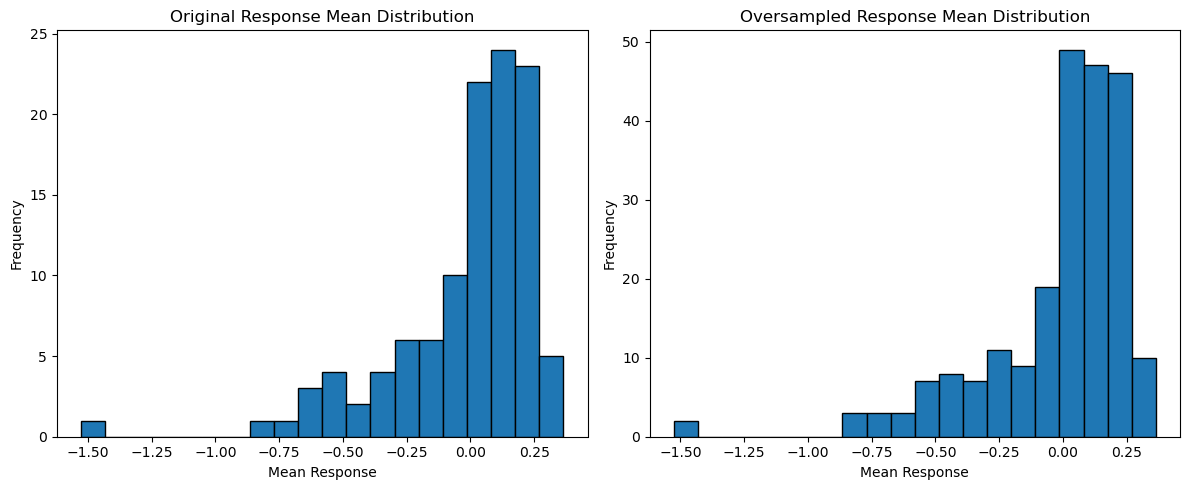


Original Data:
Number of samples: 112
Feature dimensions: 128

Oversampled Data:
Number of samples: 224
Feature dimensions: 128

Statistical Comparison:
Original Data Mean: -0.020188919647500064
Original Data Std: 0.28908687851219605
Oversampled Data Mean: -0.01902069274300433
Oversampled Data Std: 0.29119593164613405

Oversampling Diagnosis:
Original Data Bin Counts: [23 22 22 22 23]
Oversampled Data Bin Counts: [46 44 44 46 44]


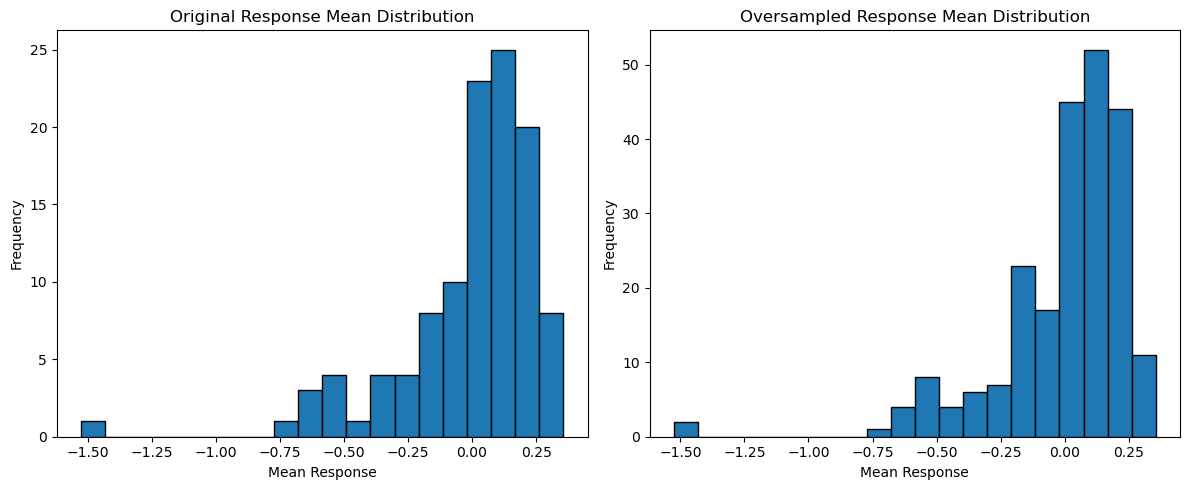


Original Data:
Number of samples: 112
Feature dimensions: 128

Oversampled Data:
Number of samples: 224
Feature dimensions: 128

Statistical Comparison:
Original Data Mean: -0.010790899679140055
Original Data Std: 0.274050675218661
Oversampled Data Mean: -0.006733384084469218
Oversampled Data Std: 0.2628864558922627


In [13]:
# Select target proteins - using high variance proteins
target_proteins = selected_proteomics.columns.tolist()
Y = selected_proteomics[target_proteins]

# Prepare input features by concatenating PCA components from multiple omics
X_pca_dfs = []
for omics in input_omics:
    if omics in pca_datasets:

        component_cols = [f"{omics}_PC{i+1}" for i in range(pca_datasets[omics].shape[1])]
        df = pd.DataFrame(pca_datasets[omics], index=aligned_datasets[omics].index, columns=component_cols)
        X_pca_dfs.append(df)

# Now concatenate the DataFrames
X = pd.concat(X_pca_dfs, axis=1)
print(f"\nInput feature matrix shape after PCA: {X.shape}")
print(f"Target matrix shape: {Y.shape}")

# Prepare base data
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.3, random_state=42)

# Scale data
scaler_X = RobustScaler()
scaler_Y = RobustScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_val_scaled = scaler_Y.transform(Y_val)
Y_test_scaled = scaler_Y.transform(Y_test)

# Setup cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Combine training and validation data for cross-validation
X_combined = np.vstack([X_train_scaled, X_val_scaled])
Y_combined = np.vstack([Y_train_scaled, Y_val_scaled])

# Store fold information
fold_data = []

# Iterate through folds
for fold, (train_idx, val_idx) in enumerate(kf.split(X_combined), 1):
    # Split data for this fold
    X_train_fold, X_val_fold = X_combined[train_idx], X_combined[val_idx]
    Y_train_fold, Y_val_fold = Y_combined[train_idx], Y_combined[val_idx]

    # Apply oversampling to training data
    X_train_oversampled, Y_train_oversampled = create_oversampled_data(
        X_train_fold,
        Y_train_fold,
        oversampling_factor=2
    )

    # Diagnose oversampling
    diagnose_oversampling(X_train_fold, Y_train_fold,
                          X_train_oversampled, Y_train_oversampled) # Test resulting sample sizes

    # Store fold information
    fold_data.append({
        'fold': fold,
        'X_train_oversampled': X_train_oversampled,
        'Y_train_oversampled': Y_train_oversampled,
        'X_val_fold': X_val_fold,
        'Y_val_fold': Y_val_fold,
        'X_test_scaled': X_test_scaled,
        'Y_test_scaled': Y_test_scaled
    })


## Machine Learning 🤖
### Baseline models

I implemented linear and ridge regression as baseline models across all cross-validation folds. These models serve as benchmarks for protein expression prediction. For ridge regression, I explored multiple regularisation strengths (α values of 0.1, 1.0, and 10.0), selecting the optimal value based on validation set performance. I evaluated all models using MSE, RMSE and MAE metrics, calculated both globally and per protein target, with results aggregated (averaged) across folds.

In [14]:
results = run_baselines_on_folds(fold_data, target_proteins, scaler_Y, n_jobs=-1)
aggregated_results = get_aggregated_results(results)
print_results(aggregated_results)


===== AGGREGATED RESULTS =====

LINEAR_REGRESSION Cross-Validation Results:
Overall MSE: 1.483289
Overall RMSE: 1.194956
Overall MAE: 0.827741

Feature-wise Metrics:
      feature       mse      rmse       mae        r2   pearson
570     GTF2I  0.213121  0.458268  0.355996  0.433740  0.804016
806      MID1  0.234737  0.478809  0.366041  0.517661  0.807017
1225  SMARCA4  0.266892  0.500690  0.378493  0.387841  0.811117
818      MSI2  0.413178  0.585505  0.406054  0.108241  0.784953
28     ACTL6A  0.320152  0.529962  0.409850  0.451082  0.843798
579      HADH  0.346610  0.569612  0.416876  0.097770  0.748495
1135     RPA2  0.314308  0.557132  0.417026  0.585401  0.803110
545    GOLGA1  0.359641  0.581852  0.420694  0.401706  0.792064
26      ACSL3  0.345397  0.577968  0.423422  0.243790  0.764693
326     DCAF7  0.351341  0.581620  0.428411  0.287987  0.718877
1431    USP13  0.327453  0.564120  0.431618  0.410676  0.720647
320   CYP27A1  0.350643  0.571754  0.434881  0.413124  0.811118
1

### Transformer model

For my main model, I used a transformer-based architecture with 8 transformer blocks and 4 attention heads. The model uses sinusoidal positional encoding, multi-head self-attention mechanisms, and global attention pooling. Each transformer block incorporates layer normalisation, residual connections, and GELU activations in the feed-forward network. For training, I employed the AdamW optimiser with a learning rate of 0.001 and weight decay of 1e-2 for L2 regularisation. I implemented several regularisation techniques including dropout (0.2), gradient clipping, and learning rate scheduling via ReduceLROnPlateau. The model was trained for up to 150 epochs with early stopping (patience of 10) using MSE loss on batches of 16 samples. Cross-validation across multiple folds ensured robust evaluation, with model selection based on validation loss performance. For more details, please see: **utils/transformer_utils.py**

Using device: cpu
Input dimension: 128, Output dimension: 1477

Processing Fold 1:
Starting training...
Epoch 10/150, Train Loss: 0.249430, Val Loss: 0.357987
Epoch 20/150, Train Loss: 0.135272, Val Loss: 0.278256
Epoch 30/150, Train Loss: 0.096705, Val Loss: 0.248064
Epoch 40/150, Train Loss: 0.066317, Val Loss: 0.236898
Epoch 50/150, Train Loss: 0.059131, Val Loss: 0.240690
Epoch 60/150, Train Loss: 0.052044, Val Loss: 0.232907
Early stopping at epoch 64
Fold 1 completed. Best validation loss: 0.226433
Overall test MSE: 0.289572

Processing Fold 2:
Starting training...
Epoch 10/150, Train Loss: 0.245502, Val Loss: 0.393548
Epoch 20/150, Train Loss: 0.136713, Val Loss: 0.290238
Epoch 30/150, Train Loss: 0.098634, Val Loss: 0.247144
Epoch 40/150, Train Loss: 0.072185, Val Loss: 0.231719
Epoch 50/150, Train Loss: 0.058522, Val Loss: 0.223541
Epoch 60/150, Train Loss: 0.048380, Val Loss: 0.218668
Epoch 70/150, Train Loss: 0.042457, Val Loss: 0.217865
Epoch 80/150, Train Loss: 0.031275, V

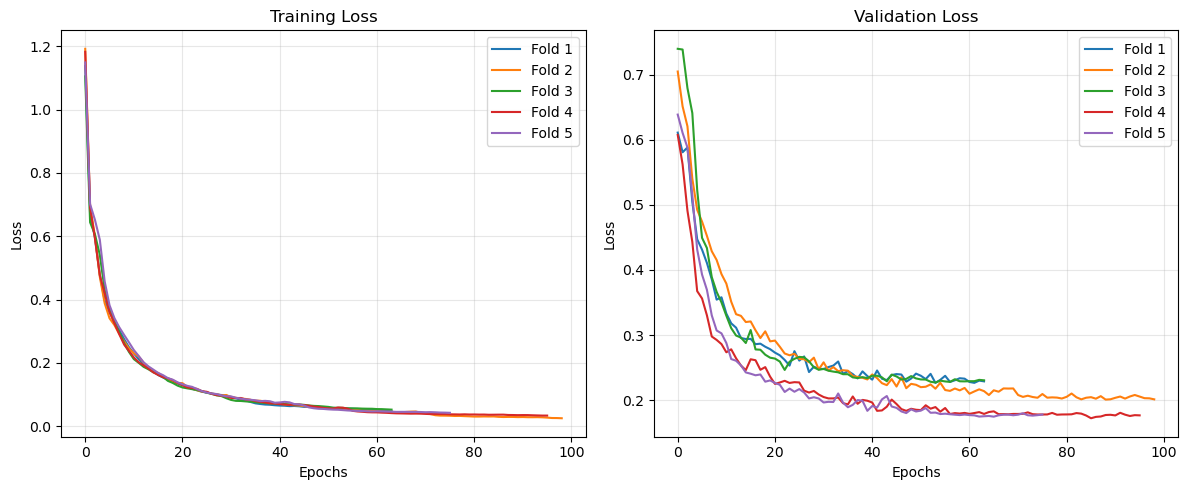

      feature       mse      rmse       mae        r2   pearson
1335    TMOD3  0.076764  0.274939  0.214906  0.868058  0.937054
1320     TJP1  0.080433  0.282047  0.225828  0.722865  0.867416
830   MYBBP1A  0.083548  0.287855  0.231538  0.770910  0.885960
462      FAF2  0.085351  0.290803  0.229464  0.804396  0.901451
351      DLG3  0.091732  0.301424  0.233390  0.683615  0.867892
300       CTH  0.095077  0.304539  0.237898  0.809015  0.901527
10     ABLIM1  0.095628  0.305432  0.243921  0.844139  0.927066
1306  TERF2IP  0.096171  0.309108  0.239606  0.828964  0.922939
400    EIF2B3  0.097502  0.307347  0.224746  0.842281  0.923388
1434    VAMP8  0.098398  0.310891  0.243156  0.848595  0.925764
967      PECR  0.099298  0.311686  0.235452  0.842937  0.922424
1120     RFC2  0.102262  0.318465  0.236821  0.803248  0.900395
1011   PLXNB2  0.103203  0.320872  0.250663  0.806749  0.902721
362     DNMBP  0.103773  0.317019  0.240352  0.743737  0.877231
333     DCTN4  0.103931  0.316392  0.243

In [15]:
d_model, n_layers, heads = 512, 8, 4

# Train transformer model
transformer_results = train_and_evaluate_transformer_on_folds(
    d_model, n_layers, heads,
    fold_data=fold_data,  
    target_proteins=target_proteins, 
    scaler_Y=scaler_Y 
)

# Aggregate results across folds
aggregated_transformer = aggregate_fold_results(transformer_results)

# Plot training curves
plot_training_curves(transformer_results)

print(aggregated_transformer['feature_metrics'].sort_values(by='mse').head(20))


## Evaluation 📊

### Overall results

I evaluated the baseline and transformer models using 5-fold cross-validation, and report the aggregated (average) performance metrics on the held-out test set.
When comparing to our baseline, the transformer has a similar overall performance to ridge regression, but performs slightly worse.


===== ALL MODELS COMPARISON =====
model         linear_regression  ridge_regression  transformer
metric                                                        
overall_mse            1.483289          0.295157     0.299659
overall_rmse           1.194956          0.542959     0.546609
overall_mae            0.827741          0.397202     0.395879


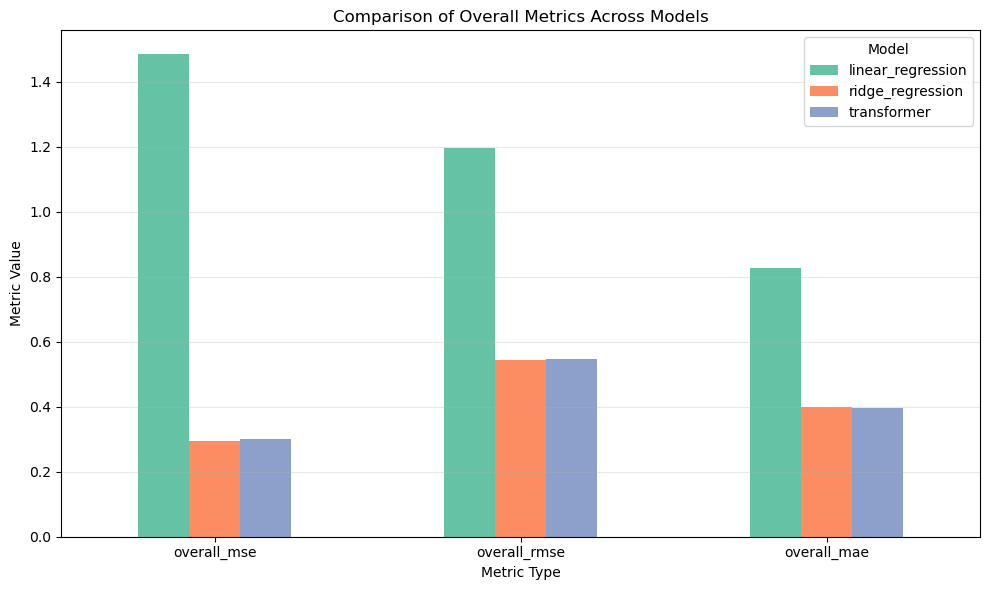

In [16]:
# Step 5: Compare all models
all_models_comparison = compare_all_models(
    baseline_results=aggregated_results,
    transformer_results=aggregated_transformer 
)

print("\n===== ALL MODELS COMPARISON =====")
print(all_models_comparison.loc[['overall_mse', 'overall_rmse', 'overall_mae']])

# Visualise comparison
visualise_model_comparison(all_models_comparison)

### Per-protein results

The MAE comparison across top proteins reveals that linear regression (green) consistently yields the highest prediction errors. Both ridge regression (orange) and the transformer model (blue) show substantial improvements, with ridge regression performing best for most proteins. The transformer model outperforms on specific proteins, suggesting that while ridge regression offers a strong general solution, the transformer's benefits are protein-specific rather than universal.

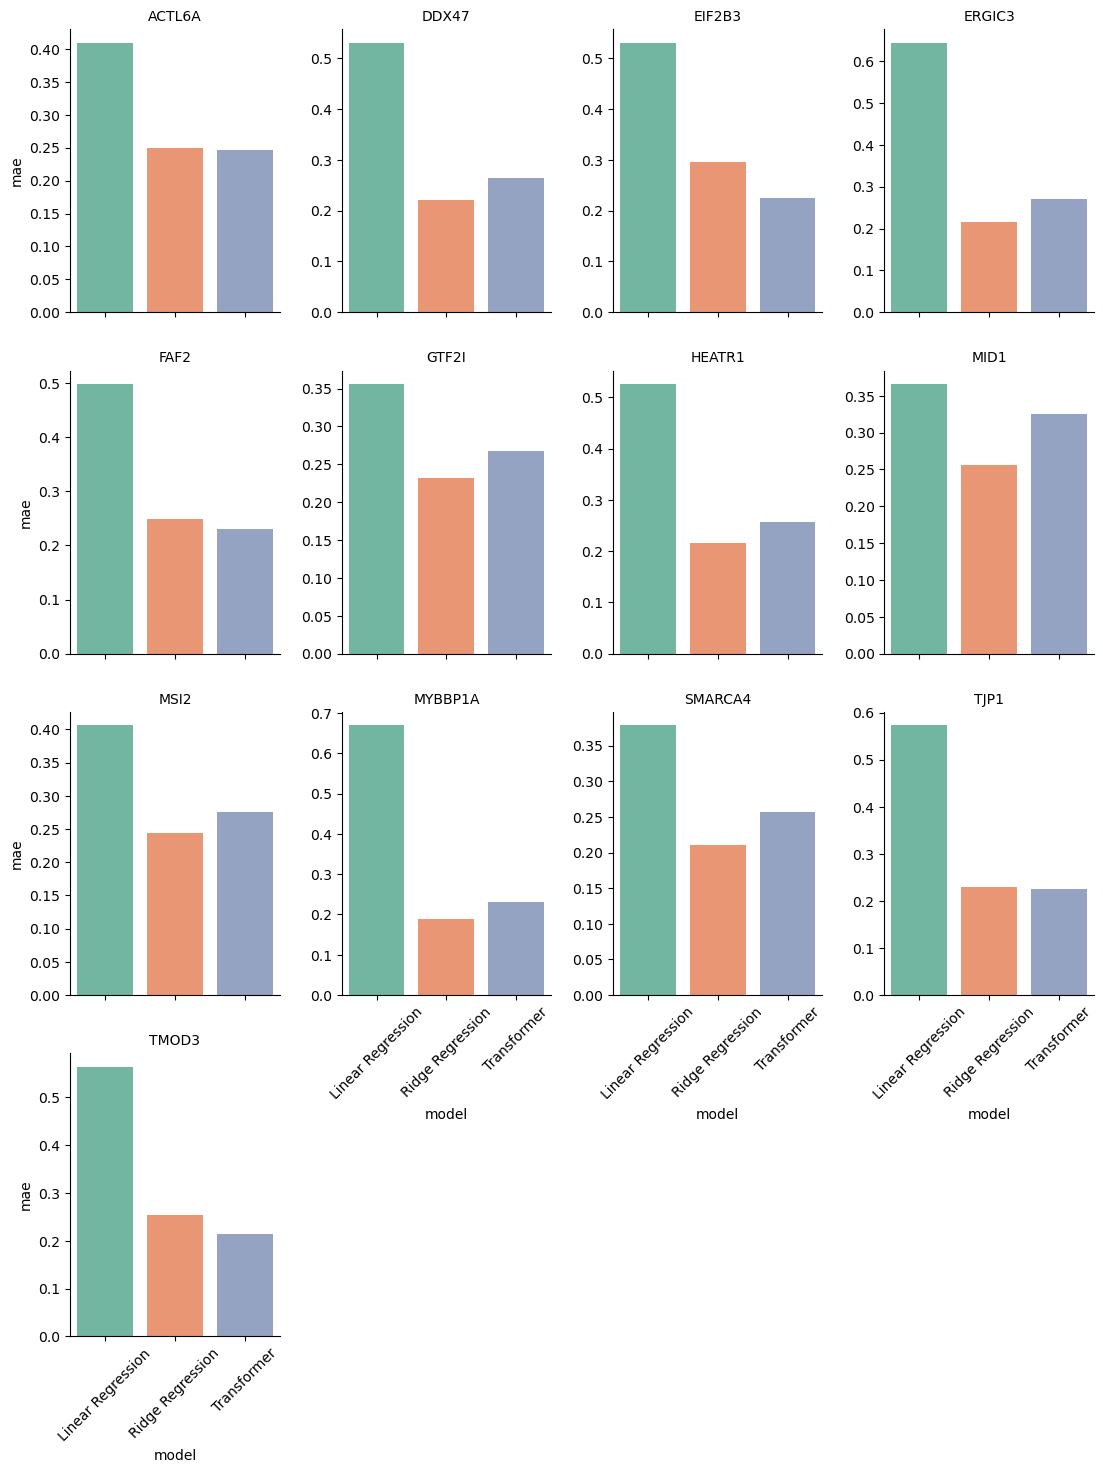

In [17]:
# Prepare model-wise DataFrames
lr = aggregated_results['linear_regression']['feature_metrics'][['feature', 'mae']].copy()
lr['model'] = 'Linear Regression'

ridge = aggregated_results['ridge_regression']['feature_metrics'][['feature', 'mae']].copy()
ridge['model'] = 'Ridge Regression'

tf = aggregated_transformer['feature_metrics'][['feature', 'mae']].copy()
tf['model'] = 'Transformer'

# Combine all into one
combined = pd.concat([lr, ridge, tf], ignore_index=True)

# Find top 10 proteins per model (lowest MAE), and store all protein names
top_proteins = []
for model_name in combined['model'].unique():
    top_feats = combined[combined['model'] == model_name].nsmallest(5, 'mae')['feature']
    top_proteins.extend(top_feats.tolist())

# Deduplicate protein names
top_proteins = list(set(top_proteins))

# Filter combined DataFrame to only those top proteins
top_combined = combined[combined['feature'].isin(top_proteins)].copy()
top_combined['feature'] = top_combined['feature'].astype(str)

# Ensure clean index
top_combined.reset_index(drop=True, inplace=True)

g = sns.catplot(
    data=top_combined,
    x="model",
    y="mae",
    col="feature",
    kind="bar",
    col_wrap=4,
    sharey=False,
    height=3.5,
    aspect=0.8,
    palette="Set2"
)

g.set_titles("{col_name}")
#g.subplots_adjust(top=0.9)
#g.suptitle("MAE Across Models for Top Proteins (Top 5 Per Model)")

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)


### Top proteins per model

This table presents the top 10 proteins with lowest prediction errors for each model. Ridge regression achieves the best overall performance, followed by the transformer model, with linear regression showing substantially higher errors. Each model is good at predicting different proteins, with limited overlap across the rankings. Only a few proteins appear in multiple models' top 10 lists, suggesting that ensemble approaches combining these models might leverage their complementary prediction strengths for different protein targets.


In [18]:
# Get top 10 proteins by MAE for each model
top_per_model = (
    combined.groupby('model')
    .apply(lambda df: df.nsmallest(10, 'mae'))
    .reset_index(drop=True)
)

# For each model, get (protein, mae) pairs as strings
def format_top(df):
    return [f"{row['feature']} ({row['mae']:.3f})" for _, row in df.iterrows()]

table_data = (
    top_per_model.groupby('model')
    .apply(format_top)
    .reset_index()
)

# Convert to table layout
top_table = pd.DataFrame(table_data[0].tolist(), index=table_data['model']).T
top_table.columns.name = "Model"
top_table.index = [f"Rank {i+1}" for i in range(top_table.shape[0])]

# Display the table
import IPython.display as display
display.display(top_table)



Model,Linear Regression,Ridge Regression,Transformer
Rank 1,GTF2I (0.356),MYBBP1A (0.190),TMOD3 (0.215)
Rank 2,MID1 (0.366),SMARCA4 (0.211),EIF2B3 (0.225)
Rank 3,SMARCA4 (0.378),HEATR1 (0.216),TJP1 (0.226)
Rank 4,MSI2 (0.406),ERGIC3 (0.216),FAF2 (0.229)
Rank 5,ACTL6A (0.410),DDX47 (0.221),MYBBP1A (0.232)
Rank 6,HADH (0.417),ABLIM1 (0.230),RFC4 (0.233)
Rank 7,RPA2 (0.417),TJP1 (0.230),DLG3 (0.233)
Rank 8,GOLGA1 (0.421),DLG3 (0.232),PECR (0.235)
Rank 9,ACSL3 (0.423),GTF2I (0.232),RFC2 (0.237)
Rank 10,DCAF7 (0.428),CLN5 (0.234),CTH (0.238)


## Future Work 🔜

### Advanced Fusion Strategies

Building on our current early fusion approach, we would explore:

- **Late Fusion**: Train separate encoders for each omics type, then combine their embeddings before prediction
- **Hierarchical Fusion**: Implement a fusion strategy that respects the biological hierarchy (DNA → RNA → protein) by passing information sequentially through modality-specific encoders
- **Cross-Attention Mechanisms**: Design transformer blocks that allow each modality to attend to others, capturing inter-omic relationships more effectively than simple concatenation
- **Modality-Specific Encoders**: Develop specialised architectures for each data type, followed by learnable fusion layers that respect their unique characteristics

### Transformer Architecture Refinement
To optimise our transformer architecture:

- **Hyperparameter Optimisation**: Conduct systematic tuning of layer count, head count, embedding dimensions, and regularisation strength
- **Alternative Attention Mechanisms**: Explore sparse or structured attention patterns that might better capture biological relationships

### Additional Omics Modalities

To enhance the model's predictive capabilities, we would incorporate:

- **Copy Number Variation**: Capture genomic structural influences and gene dosage effects common in cancer
- **Gene Fusion Data**: Include information about fusion genes that may significantly alter protein expression
- **Genomic Variants**: Integrate SNPs and indels that may affect protein expression through coding or regulatory changes
- **Additional Epigenomic Features**: Expand beyond methylation to include histone modifications and chromatin accessibility

### Integration with Foundation Models

A particularly promising direction involves leveraging existing foundation models:

- **Genomic Language Models**: Incorporate representations from models like Evo-2, which has been trained on vast amounts of evolutionary sequence data and captures complex protein structure-function relationships. These embeddings would add an additional predictive modality, potentially improving performance for proteins where sequence features are highly informative. Evo-2 can be used to represent SNPs and indels.


### Ensemble and Hybrid Approaches

Based on our observations of model performance:

- **Complementary Model Ensembles**: Develop methods combining transformer predictions with ridge regression
- **Protein-Specific Strategies**: Create targeted prediction approaches for different protein classes based on our finding that model performance varies significantly by protein target

As we incorporate more diverse data types and advanced integration methods, the transformer architecture would likely better leverage its capacity to model complex relationships across modalities. The current performance parity with ridge regression likely reflects limitations in data volume and diversity rather than architectural constraints. Despite adding complexity, incorporating foundation models like Evo-2 as an additional modality could provide valuable orthogonal information that might help overcome the limitations of our small dataset size (but this does come at a cost of increasing dimensionality...).

### Addressing the Curse of Dimensionality

Our current approach faces significant challenges related to the curse of dimensionality, as our multi-omic dataset contains thousands of features but relatively few samples. To address this limitation, I propose several strategies:

1. **Transfer Learning Approaches**: Pre-training on larger multi-omic datasets could create general representations that capture broad biological relationships. These models could then be fine-tuned on our lung-specific data, potentially allowing the transformer to leverage patterns learned from much larger datasets.

2. **Single-Cell Integration**: Single-cell multi-omic datasets provide thousands of observations within a single sample. By developing models that bridge single-cell and bulk tissue measurements, we could dramatically increase effective sample size while capturing cellular heterogeneity, which would help address the dimensionality challenge inherent in our current dataset.

3. **Knowledge-Guided Architecture**: Incorporating biological prior knowledge into the model architecture could reduce the effective dimensionality. For example, constraining attention patterns based on known regulatory relationships could help the model focus on biologically plausible relationships rather than spurious correlations.
